In [45]:
import os
import shutil
import random
import time
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

In [6]:
CONFIG = {
    'image_size': 96,
    'batch_size': 64,
    'embedding_dim': 128,
    'margin': 0.6,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'num_epochs': 50,
    'patience': 7,
    'data_dir': '/kaggle/working/Soco_Altered_Combined',
    'model_save_path': '/kaggle/working/Models_combined',
    'seed': 42
}

In [2]:
class FingerprintDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        
        # Get all classes
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Collect images per class
        self.class_images = {}
        for cls in self.classes:
            class_dir = os.path.join(data_dir, cls)
            images = [f for f in os.listdir(class_dir) if f.lower().endswith('.bmp')]
            self.class_images[cls] = images
        
        # Create splits (70% train, 15% val, 15% test)
        total_classes = len(self.classes)
        val_test_classes = int(0.3 * total_classes)
        train_classes = total_classes - val_test_classes
        val_classes = val_test_classes // 2
        test_classes = val_test_classes - val_classes
        
        random.shuffle(self.classes)
        if split == 'train':
            self.classes = self.classes[:train_classes]
        elif split == 'val':
            self.classes = self.classes[train_classes:train_classes + val_classes]
        else:  # test
            self.classes = self.classes[train_classes + val_classes:]
        
        # Create triplet samples
        self.samples = []
        for cls in self.classes:
            if len(self.class_images[cls]) >= 2:
                self.samples.append(cls)
        
    def __len__(self):
        return len(self.samples) * 10
    
    def __getitem__(self, idx):
        cls_idx = idx % len(self.samples)
        anchor_class = self.samples[cls_idx]
        
        anchor_positive_images = self.class_images[anchor_class]
        anchor_img_name, positive_img_name = random.sample(anchor_positive_images, 2)
        
        negative_class = random.choice([c for c in self.samples if c != anchor_class])
        negative_img_name = random.choice(self.class_images[negative_class])
        
        anchor_path = os.path.join(self.data_dir, anchor_class, anchor_img_name)
        positive_path = os.path.join(self.data_dir, anchor_class, positive_img_name)
        negative_path = os.path.join(self.data_dir, negative_class, negative_img_name)
        
        anchor_img = Image.open(anchor_path).convert('L')
        positive_img = Image.open(positive_path).convert('L')
        negative_img = Image.open(negative_path).convert('L')
        
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img, torch.tensor(self.class_to_idx[anchor_class])

In [5]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=CONFIG['embedding_dim']):
        super(SiameseNetwork, self).__init__()
        
        # First conv block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Second conv block with attention
        self.conv2_main = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.skip_conv2 = nn.Conv2d(32, 64, kernel_size=1)
        self.att2 = AttentionBlock(64)
        self.pool2 = nn.MaxPool2d(2)
        
        # Third conv block with attention
        self.conv3_main = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.skip_conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.att3 = AttentionBlock(128)
        self.pool3 = nn.MaxPool2d(2)
        
        # Fourth conv block with attention
        self.conv4_main = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.skip_conv4 = nn.Conv2d(128, 256, kernel_size=1)
        self.att4 = AttentionBlock(256)
        self.pool4 = nn.MaxPool2d(2)
        
        # Calculate output dimensions
        conv_output_size = CONFIG['image_size'] // 16
        self.conv_output_dim = 256 * conv_output_size * conv_output_size
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.conv_output_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
        )
    
    def forward_one(self, x):
        # First block
        x = self.conv1(x)
        
        # Second block with attention
        x_main = self.conv2_main(x)
        x_skip = self.skip_conv2(x)
        x = F.relu(x_main + x_skip)
        x = self.att2(x)
        x = self.pool2(x)
        
        # Third block with attention
        x_main = self.conv3_main(x)
        x_skip = self.skip_conv3(x)
        x = F.relu(x_main + x_skip)
        x = self.att3(x)
        x = self.pool3(x)
        
        # Fourth block with attention
        x_main = self.conv4_main(x)
        x_skip = self.skip_conv4(x)
        x = F.relu(x_main + x_skip)
        x = self.att4(x)
        x = self.pool4(x)
        
        # Flatten and pass through FC layers
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x
    
    def forward(self, anchor, positive, negative):
        anchor_out = self.forward_one(anchor)
        positive_out = self.forward_one(positive)
        negative_out = self.forward_one(negative)
        return anchor_out, positive_out, negative_out

In [8]:
class HardTripletMiner:
    def __init__(self, model, device, mining_strategy='hardest'):
        """
        Hard triplet mining implementation for fingerprint recognition
        
        Args:
            model: trained or in-training Siamese network
            device: torch device (cuda/cpu)
            mining_strategy: 'hardest' or 'semi-hard'
        """
        self.model = model
        self.device = device
        self.mining_strategy = mining_strategy
        
    def mine_triplets(self, dataloader, num_triplets=1000):
        """
        Mine hard triplets from the given dataloader
        
        Args:
            dataloader: PyTorch dataloader containing fingerprint images with class labels
            num_triplets: number of hard triplets to mine
            
        Returns:
            list of hard triplets (anchor, positive, negative)
        """
        self.model.eval()
        class_to_images = {}
        embeddings_dict = {}
        
        # Extract embeddings for all images
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Extracting embeddings")):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass to get embeddings
                embeddings = self.model.forward_one(images)
                
                # Store embeddings by class
                for i in range(len(labels)):
                    label = labels[i].item()
                    if label not in class_to_images:
                        class_to_images[label] = []
                    
                    img_idx = batch_idx * dataloader.batch_size + i
                    class_to_images[label].append(img_idx)
                    embeddings_dict[img_idx] = embeddings[i]
        
        # Mine hard triplets
        hard_triplets = []
        classes = list(class_to_images.keys())
        
        for _ in tqdm(range(num_triplets), desc="Mining hard triplets"):
            # Randomly choose anchor class
            anchor_class = random.choice(classes)
            
            # Only proceed if class has at least 2 samples
            if len(class_to_images[anchor_class]) < 2:
                continue
                
            # Randomly select anchor and positive
            anchor_idx, positive_idx = random.sample(class_to_images[anchor_class], 2)
            anchor_embedding = embeddings_dict[anchor_idx]
            positive_embedding = embeddings_dict[positive_idx]
            
            # Compute distance between anchor and positive
            self.anchor_positive_distance = F.pairwise_distance(
                anchor_embedding.unsqueeze(0), 
                positive_embedding.unsqueeze(0)
            ).item()
            
            # Find hard negative
            negative_idx = self._find_hard_negative(
                anchor_embedding, 
                embeddings_dict, 
                class_to_images, 
                anchor_class
            )
            
            hard_triplets.append((anchor_idx, positive_idx, negative_idx))
            
        return hard_triplets
    
    def _find_hard_negative(self, anchor_embedding, embeddings_dict, class_to_images, anchor_class):
        """Find hard negative sample based on the mining strategy"""
        
        hardest_negative_idx = None
        hardest_negative_distance = float('inf')
        semi_hard_negative_idx = None
        semi_hard_negative_distance = float('inf')
        
        # Iterate through all classes except anchor class
        negative_classes = [c for c in class_to_images.keys() if c != anchor_class]
        
        for neg_class in negative_classes:
            for neg_idx in class_to_images[neg_class]:
                neg_embedding = embeddings_dict[neg_idx]
                
                # Compute distance
                distance = F.pairwise_distance(
                    anchor_embedding.unsqueeze(0),
                    neg_embedding.unsqueeze(0)
                ).item()
                
                # Track closest negative (hardest)
                if distance < hardest_negative_distance:
                    hardest_negative_distance = distance
                    hardest_negative_idx = neg_idx
                
                # Semi-hard: negatives that are closer than the positive but not too close
                if distance < self.anchor_positive_distance and distance > hardest_negative_distance:
                    if distance < semi_hard_negative_distance:
                        semi_hard_negative_distance = distance
                        semi_hard_negative_idx = neg_idx
        
        # Return based on strategy
        if self.mining_strategy == 'semi-hard' and semi_hard_negative_idx is not None:
            return semi_hard_negative_idx
        else:
            return hardest_negative_idx

In [9]:
class HardTripletDataset(Dataset):
    def __init__(self, original_dataset, triplet_indices, transform=None):
        """
        Dataset wrapper for hard triplets
        
        Args:
            original_dataset: Original dataset with fingerprint images
            triplet_indices: List of triplet indices (anchor, positive, negative)
            transform: Optional transforms to apply
        """
        self.original_dataset = original_dataset
        self.triplet_indices = triplet_indices
        self.transform = transform
        
    def __len__(self):
        return len(self.triplet_indices)
    
    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplet_indices[idx]
        
        # Get images from original dataset
        anchor_img = self.original_dataset[anchor_idx][0]
        positive_img = self.original_dataset[positive_idx][0]
        negative_img = self.original_dataset[negative_idx][0]
        
        # Apply transforms if specified
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
            
        # Class label from anchor
        label = self.original_dataset[anchor_idx][1]
            
        return anchor_img, positive_img, negative_img, label

In [10]:
class KFoldFingerprint:
    def __init__(self, data_dir, k_folds=5, transform=None, batch_size=32, num_workers=4):
        """
        K-fold cross-validation implementation for fingerprint dataset
        
        Args:
            data_dir: Directory containing fingerprint images organized by class
            k_folds: Number of folds for cross-validation
            transform: Transforms to apply to images
            batch_size: Batch size for dataloaders
            num_workers: Number of workers for dataloaders
        """
        self.data_dir = data_dir
        self.k_folds = k_folds
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # Get all classes
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Shuffle classes for fold creation
        random.shuffle(self.classes)
        
        # Split classes into k folds
        self.folds = []
        fold_size = len(self.classes) // k_folds
        
        for i in range(k_folds):
            start_idx = i * fold_size
            end_idx = (i + 1) * fold_size if i < k_folds - 1 else len(self.classes)
            self.folds.append(self.classes[start_idx:end_idx])
    
    def get_fold_dataloaders(self, fold_idx):
        """
        Get train and validation dataloaders for specified fold
        
        Args:
            fold_idx: Index of fold to use as validation set
            
        Returns:
            train_loader, val_loader
        """
        if fold_idx < 0 or fold_idx >= self.k_folds:
            raise ValueError(f"Fold index must be between 0 and {self.k_folds-1}")
        
        # Classes for validation
        val_classes = self.folds[fold_idx]
        
        # Classes for training (all other folds)
        train_classes = []
        for i in range(self.k_folds):
            if i != fold_idx:
                train_classes.extend(self.folds[i])
        
        # Create datasets
        train_dataset = FingerprintFoldDataset(
            self.data_dir, 
            train_classes,
            transform=self.transform
        )
        
        val_dataset = FingerprintFoldDataset(
            self.data_dir,
            val_classes,
            transform=transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
                transforms.ToTensor()
            ])  # Minimal transforms for validation
        )
        
        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )
        
        return train_loader, val_loader
    
    def run_cross_validation(self, model_class, model_params, train_params, device):
        """
        Run k-fold cross-validation
        
        Args:
            model_class: Model class to instantiate
            model_params: Parameters for model instantiation
            train_params: Parameters for training (epochs, lr, etc.)
            device: Torch device (cuda/cpu)
            
        Returns:
            Dictionary with fold results and overall metrics
        """
        results = {
            'fold_metrics': [],
            'best_model_path': None,
            'best_accuracy': 0.0
        }
        
        for fold in range(self.k_folds):
            print(f"\n{'='*50}")
            print(f"Training Fold {fold+1}/{self.k_folds}")
            print(f"{'='*50}")
            
            # Get dataloaders for this fold
            train_loader, val_loader = self.get_fold_dataloaders(fold)
            
            # Initialize model
            model = model_class(**model_params).to(device)
            
            # Initialize optimizer and loss
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=train_params['learning_rate'],
                weight_decay=train_params['weight_decay']
            )
            
            criterion = TripletLoss(margin=train_params['margin'])
            
            # Train the model
            best_val_acc = 0.0
            best_model_path = f"{train_params['model_save_path']}/fold_{fold}_best.pth"
            
            for epoch in range(train_params['epochs']):
                # Training
                model.train()
                train_loss = 0.0
                
                for batch_idx, (anchor, positive, negative, _) in enumerate(train_loader):
                    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                    
                    optimizer.zero_grad()
                    
                    anchor_out, positive_out, negative_out = model(anchor, positive, negative)
                    loss = criterion(anchor_out, positive_out, negative_out)
                    
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    
                avg_train_loss = train_loss / len(train_loader)
                
                # Validation
                model.eval()
                val_accuracy = self._evaluate_model(model, val_loader, device)
                
                print(f"Epoch {epoch+1}/{train_params['epochs']} - "
                      f"Train Loss: {avg_train_loss:.4f}, "
                      f"Val Accuracy: {val_accuracy:.4f}")
                
                # Save best model
                if val_accuracy > best_val_acc:
                    best_val_acc = val_accuracy
                    torch.save(model.state_dict(), best_model_path)
                    
                    # Update overall best model if this is the best so far
                    if val_accuracy > results['best_accuracy']:
                        results['best_accuracy'] = val_accuracy
                        results['best_model_path'] = best_model_path
            
            # Record fold results
            results['fold_metrics'].append({
                'fold': fold,
                'accuracy': best_val_acc
            })
            
        # Calculate average metrics
        avg_accuracy = sum(fold['accuracy'] for fold in results['fold_metrics']) / self.k_folds
        results['average_accuracy'] = avg_accuracy
        
        print(f"\n{'='*50}")
        print(f"Cross-Validation Complete")
        print(f"Average Accuracy: {avg_accuracy:.4f}")
        print(f"Best Fold Accuracy: {results['best_accuracy']:.4f}")
        print(f"Best Model Path: {results['best_model_path']}")
        print(f"{'='*50}")
        
        return results
        
    def _evaluate_model(self, model, dataloader, device):
        """Evaluate model accuracy on verification task"""
        correct = 0
        total = 0
        
        with torch.no_grad():
            for anchor, positive, negative, _ in dataloader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                
                # Get embeddings
                anchor_out, positive_out, negative_out = model(anchor, positive, negative)
                
                # Calculate distances
                pos_dist = F.pairwise_distance(anchor_out, positive_out)
                neg_dist = F.pairwise_distance(anchor_out, negative_out)
                
                # Prediction is correct if positive distance < negative distance
                correct += torch.sum(pos_dist < neg_dist).item()
                total += anchor.size(0)
        
        return correct / total if total > 0 else 0.0

In [11]:
class FingerprintFoldDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        """
        Dataset for fingerprint fold
        
        Args:
            data_dir: Directory containing fingerprint images
            classes: List of classes to include
            transform: Optional transforms to apply
        """
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Collect images per class
        self.class_images = {}
        for cls in self.classes:
            class_dir = os.path.join(data_dir, cls)
            images = [f for f in os.listdir(class_dir) if f.lower().endswith('.bmp')]
            self.class_images[cls] = images
        
        # Create triplet samples
        self.samples = []
        for cls in self.classes:
            if len(self.class_images[cls]) >= 2:
                self.samples.append(cls)
    
    def __len__(self):
        return len(self.samples) * 10  # 10 triplets per class
    
    def __getitem__(self, idx):
        cls_idx = idx % len(self.samples)
        anchor_class = self.samples[cls_idx]
        
        anchor_positive_images = self.class_images[anchor_class]
        anchor_img_name, positive_img_name = random.sample(anchor_positive_images, 2)
        
        negative_class = random.choice([c for c in self.samples if c != anchor_class])
        negative_img_name = random.choice(self.class_images[negative_class])
        
        anchor_path = os.path.join(self.data_dir, anchor_class, anchor_img_name)
        positive_path = os.path.join(self.data_dir, anchor_class, positive_img_name)
        negative_path = os.path.join(self.data_dir, negative_class, negative_img_name)
        
        anchor_img = Image.open(anchor_path).convert('L')
        positive_img = Image.open(positive_path).convert('L')
        negative_img = Image.open(negative_path).convert('L')
        
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img, torch.tensor(self.class_to_idx[anchor_class])

In [12]:
class TripletLoss(nn.Module):
    """
    Triplet loss with hard positive and hard negative mining.
    
    Args:
        margin: Margin for triplet loss (default: 0.6)
    """
    def __init__(self, margin=0.6):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        """
        Args:
            anchor: Anchor embeddings (batch_size, embedding_dim)
            positive: Positive embeddings (batch_size, embedding_dim)
            negative: Negative embeddings (batch_size, embedding_dim)
            
        Returns:
            Triplet loss
        """
        # Calculate distances
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        
        # Compute triplet loss with margin
        losses = torch.relu(pos_dist - neg_dist + self.margin)
        
        return losses.mean()

In [13]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            return False
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.counter = 0
            return False

In [14]:
def prepare_dataset():
    print("Preparing combined dataset...")
    source_dirs = [
        ('/kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/', 'Hard'),
        ('/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium/', 'Medium')
    ]
    destination_dir = CONFIG['data_dir']
    os.makedirs(destination_dir, exist_ok=True)

    pattern = re.compile(r'.*Right_index_finger.*\.bmp$', re.IGNORECASE)

    total_images_copied = 0
    skipped_files = []
    for source_dir, suffix in source_dirs:
        print(f"\nProcessing {source_dir}")
        all_files = [f for f in os.listdir(source_dir) if f.lower().endswith(".bmp")]
        matched_files = [f for f in all_files if pattern.match(f)]
        skipped = [f for f in all_files if f not in matched_files]
        skipped_files.extend([(source_dir, f) for f in skipped])
        print(f"Found {len(matched_files)} Right_index_finger images in {source_dir}")
        print(f"Skipped {len(skipped)} BMP files in {source_dir}")
        
        for file_name in matched_files:
            class_name = file_name.split('__')[0] if '__' in file_name else file_name.split('_')[0]
            class_dir = os.path.join(destination_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            source_path = os.path.join(source_dir, file_name)
            # Append suffix to avoid overwriting (e.g., _Hard, _Medium)
            base, ext = os.path.splitext(file_name)
            new_file_name = f"{base}_{suffix}{ext}"
            destination_path = os.path.join(class_dir, new_file_name)
            shutil.copy(source_path, destination_path)
            total_images_copied += 1

    print(f"\nCombined dataset prepared at {destination_dir}")
    print(f"Total images copied: {total_images_copied}")
    if skipped_files:
        print("\nSample of skipped BMP files (up to 10):")
        for source, f in skipped_files[:10]:
            print(f"  {source}: {f}")


In [15]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (anchor, positive, negative, _) in enumerate(train_loader):
        # Move data to device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        # Forward pass
        anchor_out, positive_out, negative_out = model(anchor, positive, negative)
        
        # Calculate loss
        loss = criterion(anchor_out, positive_out, negative_out)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        running_loss += loss.item()
        
        # Calculate accuracy (for monitoring)
        pos_dist = F.pairwise_distance(anchor_out, positive_out)
        neg_dist = F.pairwise_distance(anchor_out, negative_out)
        correct += torch.sum(pos_dist < neg_dist).item()
        total += anchor.size(0)
    
    # Calculate epoch metrics
    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total if total > 0 else 0.0
    
    return avg_loss, accuracy

In [16]:
def evaluate(model, val_loader, criterion, device):
    """Evaluate model on validation set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_pos_dist = []
    all_neg_dist = []
    
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative, _) in enumerate(val_loader):
            # Move data to device
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            # Forward pass
            anchor_out, positive_out, negative_out = model(anchor, positive, negative)
            
            # Calculate loss
            loss = criterion(anchor_out, positive_out, negative_out)
            running_loss += loss.item()
            
            # Calculate distances
            pos_dist = F.pairwise_distance(anchor_out, positive_out)
            neg_dist = F.pairwise_distance(anchor_out, negative_out)
            
            # Store distances for ROC curve calculation
            all_pos_dist.extend(pos_dist.cpu().numpy())
            all_neg_dist.extend(neg_dist.cpu().numpy())
            
            # Calculate accuracy
            correct += torch.sum(pos_dist < neg_dist).item()
            total += anchor.size(0)
    
    # Calculate metrics
    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total if total > 0 else 0.0
    
    return avg_loss, accuracy, all_pos_dist, all_neg_dist


In [17]:
def calculate_roc(pos_distances, neg_distances):
    """Calculate ROC curve points and AUC"""
    # Combine all distances
    all_distances = pos_distances + neg_distances 
    all_labels = [1] * len(pos_distances) + [0] * len(neg_distances)
    
    # Convert to numpy arrays
    all_distances = np.array(all_distances)
    all_labels = np.array(all_labels)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, -all_distances)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, thresholds, roc_auc

In [18]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve"""
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [35]:
def visualize_embeddings(model, test_loader, device, n_samples=300):
    """Visualize fingerprint embeddings with t-SNE"""
    model.eval()
    embeddings = []
    labels = []
    count = 0
    
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative, cls_labels) in enumerate(test_loader):
            # Process anchor images
            anchor = anchor.to(device)
            anchor_emb = model.forward_one(anchor)
            
            # Store embeddings and labels
            batch_size = anchor.size(0)
            if count + batch_size > n_samples:
                # Only take what we need to reach n_samples
                needed = n_samples - count
                embeddings.append(anchor_emb[:needed].cpu().numpy())
                labels.extend(cls_labels[:needed].numpy())
                break
            else:
                embeddings.append(anchor_emb.cpu().numpy())
                labels.extend(cls_labels.numpy())
                count += batch_size
    
    # Concatenate all embeddings
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    
    # Ensure both arrays have the same number of samples
    assert len(embeddings) == len(labels), f"Mismatch: {len(embeddings)} embeddings vs {len(labels)} labels"
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                    color=colors[i], label=f'Class {label}', alpha=0.7)
    
    plt.title('t-SNE Visualization of Fingerprint Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(loc='best', bbox_to_anchor=(1.0, 1.0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_distance_distributions(pos_distances, neg_distances):
    """Plot distributions of positive and negative distances"""
    plt.figure(figsize=(10, 6))
    
    # Plot histograms
    plt.hist(pos_distances, bins=50, alpha=0.5, label='Same Person', color='green')
    plt.hist(neg_distances, bins=50, alpha=0.5, label='Different People', color='red')
    
    plt.title('Distribution of Fingerprint Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
def train_siamese_model(model, train_loader, val_loader, config):
    """
    Train siamese network for fingerprint identification
    
    Args:
        model: Siamese network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        config: Configuration dictionary
        
    Returns:
        trained_model: Trained model
        history: Training history
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Initialize optimizer, criterion, and early stopping
    optimizer = optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    criterion = TripletLoss(margin=config['margin'])
    early_stopping = EarlyStopping(patience=config['patience'])
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Create directory for saving models
    os.makedirs(config['model_save_path'], exist_ok=True)
    
    # Training loop
    best_val_acc = 0.0
    best_model_path = os.path.join(config['model_save_path'], 'best_model.pth')
    
    for epoch in range(config['num_epochs']):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Evaluate on validation set
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{config['num_epochs']} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")
        
        # Check for early stopping
        if early_stopping(val_loss):
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    model.load_state_dict(torch.load(best_model_path))
    
    return model, history

In [48]:
def identify_fingerprint(model, reference_img_path, query_img_path, threshold=1.0, device='cuda'):
    """
    Identify if two fingerprint images belong to the same person with detailed timing
    
    Args:
        model: Trained siamese network
        reference_img_path: Path to reference fingerprint image
        query_img_path: Path to query fingerprint image
        threshold: Maximum distance threshold for match
        device: Torch device
        
    Returns:
        result: String indicating if images match ("is a match" or "not a match")
        distance: Distance between fingerprint embeddings
        timing_info: Dictionary containing execution times for different steps
    """
    timing_info = {}
    total_start_time = time.time()
    
    # Load images timing
    load_start = time.time()
    reference_img = Image.open(reference_img_path)
    query_img = Image.open(query_img_path)
    timing_info['image_loading'] = time.time() - load_start
    
    # Prepare images timing
    transform_start = time.time()
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor()
    ])
    
    reference_tensor = transform(reference_img).unsqueeze(0).to(device)
    query_tensor = transform(query_img).unsqueeze(0).to(device)
    timing_info['preprocessing'] = time.time() - transform_start
    
    # Model inference timing
    model.eval()
    inference_start = time.time()
    with torch.no_grad():
        reference_emb = model.forward_one(reference_tensor)
        query_emb = model.forward_one(query_tensor)
        timing_info['model_inference'] = time.time() - inference_start
        
        # Calculate distance timing
        distance_start = time.time()
        distance = F.pairwise_distance(reference_emb, query_emb).item()
        result = "is a match" if distance < threshold else "not a match"
        timing_info['distance_calculation'] = time.time() - distance_start
    
    # Total time
    timing_info['total_time'] = time.time() - total_start_time
    
    return result, distance, timing_info

In [23]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [24]:
# Set seed for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])

In [25]:
pil_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor()
])

pil_positive_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.GaussianBlur(kernel_size=5),
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor()
])

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare dataset
prepare_dataset()

# Create datasets and dataloaders
train_dataset = FingerprintDataset(
    CONFIG['data_dir'],
    split='train',
    transform=pil_positive_transforms
)

val_dataset = FingerprintDataset(
    CONFIG['data_dir'],
    split='val',
    transform=pil_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Using device: cuda
Preparing combined dataset...

Processing /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/
Found 1305 Right_index_finger images in /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/
Skipped 12967 BMP files in /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/

Processing /kaggle/input/socofing/SOCOFing/Altered/Altered-Medium/
Found 1636 Right_index_finger images in /kaggle/input/socofing/SOCOFing/Altered/Altered-Medium/
Skipped 15431 BMP files in /kaggle/input/socofing/SOCOFing/Altered/Altered-Medium/

Combined dataset prepared at /kaggle/working/Soco_Altered_Combined
Total images copied: 2941

Sample of skipped BMP files (up to 10):
  /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/: 301__F_Right_ring_finger_Zcut.BMP
  /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/: 490__M_Left_middle_finger_CR.BMP
  /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/: 546__M_Left_index_finger_Zcut.BMP
  /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard/:

In [30]:
model = SiameseNetwork(embedding_dim=CONFIG['embedding_dim']).to(device)

# Train model
trained_model, history = train_siamese_model(model, train_loader, val_loader, CONFIG)

Epoch 1/50 - Train Loss: 0.4567, Train Acc: 0.6660, Val Loss: 0.1868, Val Acc: 0.9544
Saved best model with validation accuracy: 0.9544
Epoch 2/50 - Train Loss: 0.2968, Train Acc: 0.7952, Val Loss: 0.0363, Val Acc: 0.9933
Saved best model with validation accuracy: 0.9933
Epoch 3/50 - Train Loss: 0.2053, Train Acc: 0.8762, Val Loss: 0.0235, Val Acc: 1.0000
Saved best model with validation accuracy: 1.0000
Epoch 4/50 - Train Loss: 0.1826, Train Acc: 0.8919, Val Loss: 0.0450, Val Acc: 0.9933
Epoch 5/50 - Train Loss: 0.1687, Train Acc: 0.9033, Val Loss: 0.0324, Val Acc: 0.9922
Epoch 6/50 - Train Loss: 0.1493, Train Acc: 0.9155, Val Loss: 0.0281, Val Acc: 0.9978
Epoch 7/50 - Train Loss: 0.1445, Train Acc: 0.9276, Val Loss: 0.0224, Val Acc: 0.9989
Epoch 8/50 - Train Loss: 0.1358, Train Acc: 0.9340, Val Loss: 0.0134, Val Acc: 1.0000
Epoch 9/50 - Train Loss: 0.1230, Train Acc: 0.9407, Val Loss: 0.0218, Val Acc: 1.0000
Epoch 10/50 - Train Loss: 0.1178, Train Acc: 0.9426, Val Loss: 0.0286, Val A

/tmp/ipykernel_31/4114453624.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [31]:
# Evaluate final model
_, val_acc, pos_dist, neg_dist = evaluate(trained_model, val_loader, TripletLoss(margin=CONFIG['margin']), device)
print(f"Final validation accuracy: {val_acc:.4f}")

Final validation accuracy: 0.9978


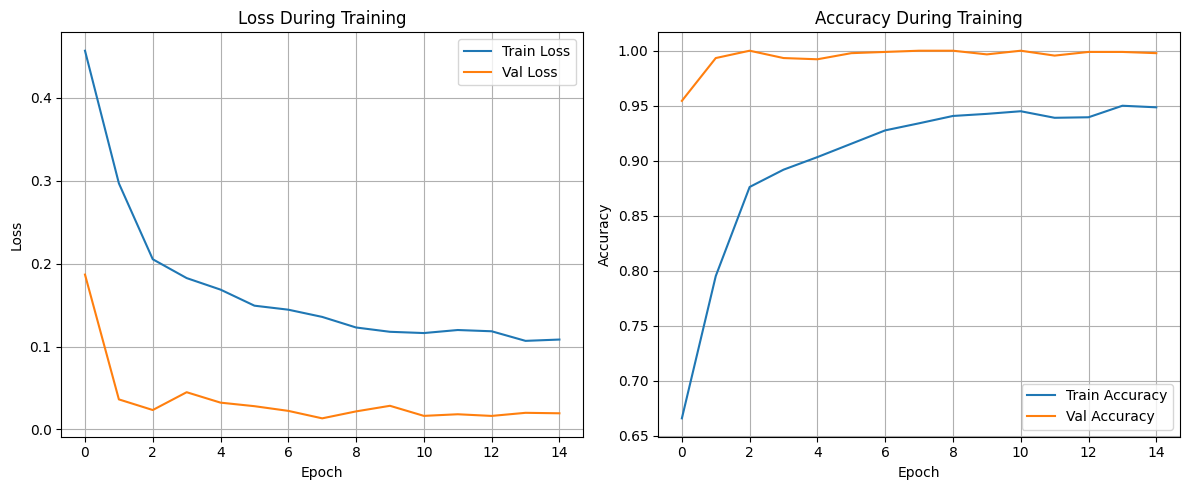

In [32]:
# Plot training history
plot_training_history(history)

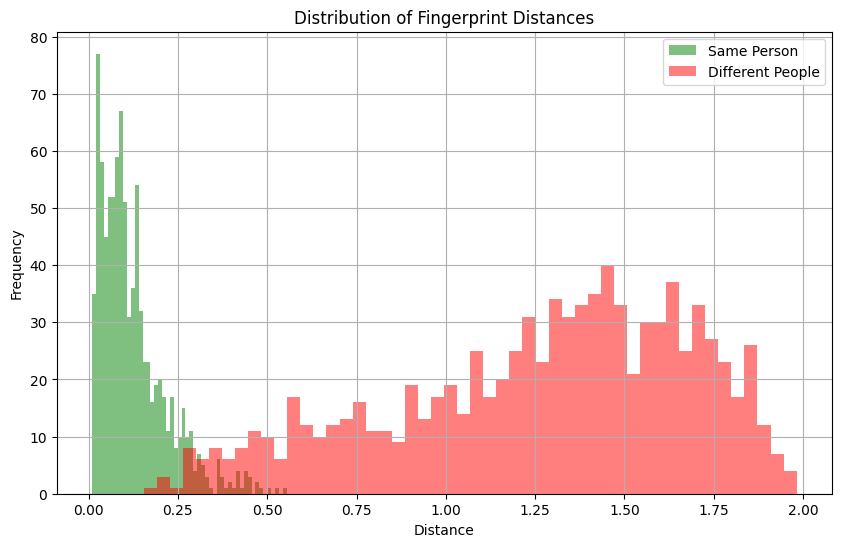

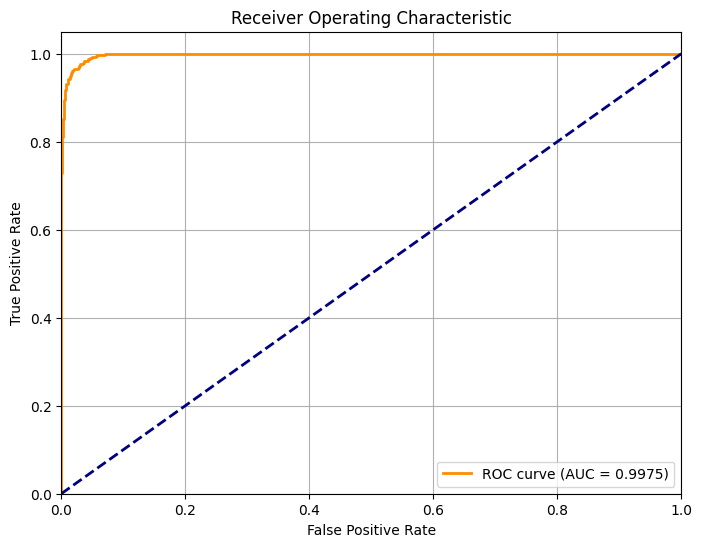

In [33]:
# Plot distance distributions
plot_distance_distributions(pos_dist, neg_dist)

# Calculate and plot ROC curve
fpr, tpr, thresholds, roc_auc = calculate_roc(pos_dist, neg_dist)
plot_roc_curve(fpr, tpr, roc_auc)

/tmp/ipykernel_31/710089177.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


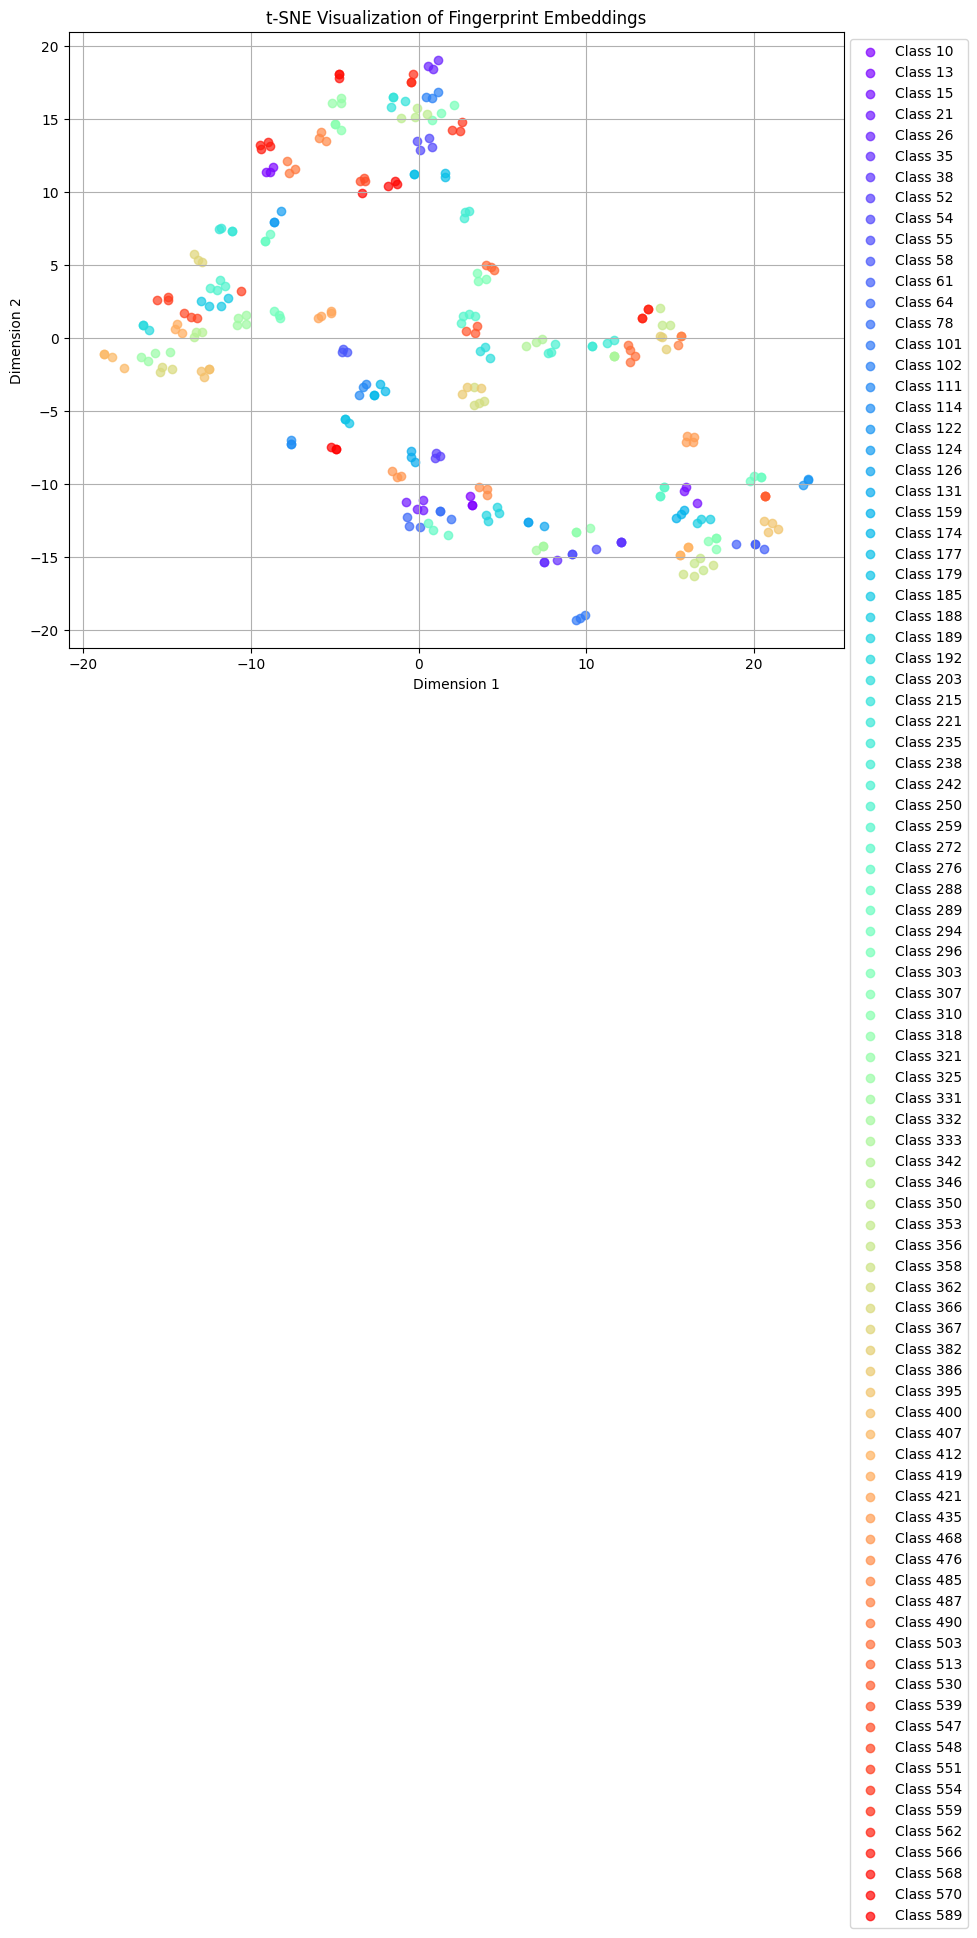

In [36]:
# Visualize embeddings
visualize_embeddings(trained_model, val_loader, device)

In [37]:
# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = -thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At optimal threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

# Save final model
final_model_path = os.path.join(CONFIG['model_save_path'], 'final_model.pth')
torch.save(trained_model.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Optimal threshold: 0.4158
At optimal threshold - TPR: 0.9844, FPR: 0.0367
Model saved to /kaggle/working/Models_combined/final_model.pth


In [49]:
result, distance, timing = identify_fingerprint(trained_model,"/kaggle/working/Soco_Altered_Combined/1/1__M_Right_index_finger_CR_Hard.BMP",
                           "/kaggle/working/Soco_Altered_Combined/10/10__M_Right_index_finger_CR_Hard.BMP")
# print(f"Result: {result}, Distance: {distance:.4f}")
# print(f"Timing breakdown:")
# for step, time_taken in timing.items():
#     print(f"  {step}: {time_taken:.4f} seconds")

In [50]:
print(f"Result: {result}, Distance: {distance:.4f}")
print(f"Timing breakdown:")
for step, time_taken in timing.items():
    print(f"  {step}: {time_taken:.4f} seconds")

Result: not a match, Distance: 1.2198
Timing breakdown:
  image_loading: 0.0009 seconds
  preprocessing: 0.0020 seconds
  model_inference: 0.0082 seconds
  distance_calculation: 0.0001 seconds
  total_time: 0.0117 seconds
